### Lecture 4: Homework

Today we gonna learn how to choose between ML models, based on data type. Your task would be to predict **the edibility of a mushroom** based on sample descriptions (binary classification problem)

The **tricky part here is that 95% of the features are of categorical type.**
<br>That's the one where we would **(usually)  prefer tree-based algorithms over linear methods**

Although this dataset was originally contributed to the UCI Machine Learning repository nearly 30 years ago, mushroom hunting (otherwise known as "shrooming") is enjoying new peaks in popularity. Learn which features spell certain death and which are most palatable in this dataset of mushroom characteristics. And how certain can your model be?

This dataset includes descriptions of hypothetical samples corresponding to 23 species of gilled mushrooms in the Agaricus and Lepiota Family Mushroom drawn from The Audubon Society Field Guide to North American Mushrooms (1981). Each species is identified as definitely edible, definitely poisonous, or of unknown edibility and not recommended. This latter class was combined with the poisonous one. The Guide clearly states that there is no simple rule for determining the edibility of a mushroom; no rule like "leaflets three, let it be'' for Poisonous Oak and Ivy.

More information can be found [here](https://www.kaggle.com/uciml/mushroom-classification/data)

In [166]:
# library import
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
%matplotlib inline

from os.path import join as pjoin
pd.options.display.max_columns = 50
pd.options.display.max_colwidth = 100

# preprocessing / validation
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
)
# ML models
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

# metrics
from sklearn.metrics import classification_report, f1_score

In [167]:
# read data
DATA_DIR = '../data'
df_train = pd.read_csv(pjoin(DATA_DIR, '4-mushrooms-train.csv'), engine='c')
df_test = pd.read_csv(pjoin(DATA_DIR, '4-mushrooms-test.csv'), engine='c')
print(df_train.shape, df_test.shape)

(6499, 23) (1625, 22)


In [168]:
# let's see what data looks like
df_train.head(2)

,target,cap_shape,cap_surface,cap_color,bruises,odor,gill_attachment,gill_spacing,gill_size,gill_color,stalk_shape,stalk_root,stalk_surface_above_ring,stalk_surface_below_ring,stalk_color_above_ring,stalk_color_below_ring,veil_type,veil_color,ring_number,ring_type,spore_print_color,population,habitat
0,0,convex,scaly,brown,bruises,pungent,free,close,narrow,white,enlarging,equal,smooth,smooth,white,white,partial,white,one,pendant,brown,scattered,urban
1,1,flat,fibrous,gray,bruises,none,free,close,broad,brown,tapering,bulbous,smooth,smooth,white,white,partial,white,one,pendant,brown,several,woods


In [169]:
# for convenient calculations, let us merge train with test
df = pd.concat([df_train, df_test], axis=0)
# add column for filtering train/test
df['is_train'] = True
df.loc[df.target.isnull(), 'is_train'] = False
# check shapes
print(df.shape)
# check labels
df.is_train.value_counts()

(8124, 24)


True     6499
False    1625
Name: is_train, dtype: int64

In [170]:
df.head(2)

,bruises,cap_color,cap_shape,cap_surface,gill_attachment,gill_color,gill_size,gill_spacing,habitat,odor,population,ring_number,ring_type,spore_print_color,stalk_color_above_ring,stalk_color_below_ring,stalk_root,stalk_shape,stalk_surface_above_ring,stalk_surface_below_ring,target,veil_color,veil_type,is_train
0,bruises,brown,convex,scaly,free,white,narrow,close,urban,pungent,scattered,one,pendant,brown,white,white,equal,enlarging,smooth,smooth,0.0,white,partial,True
1,bruises,gray,flat,fibrous,free,brown,broad,close,woods,none,several,one,pendant,brown,white,white,bulbous,tapering,smooth,smooth,1.0,white,partial,True


### Task 1. Which feature has the highest amount of unique values? (joint dataset)


In [171]:
# ---------------------------------------------------------------
most_diversive = df.nunique().idxmax()
# ---------------------------------------------------------------
print(most_diversive)

gill_color


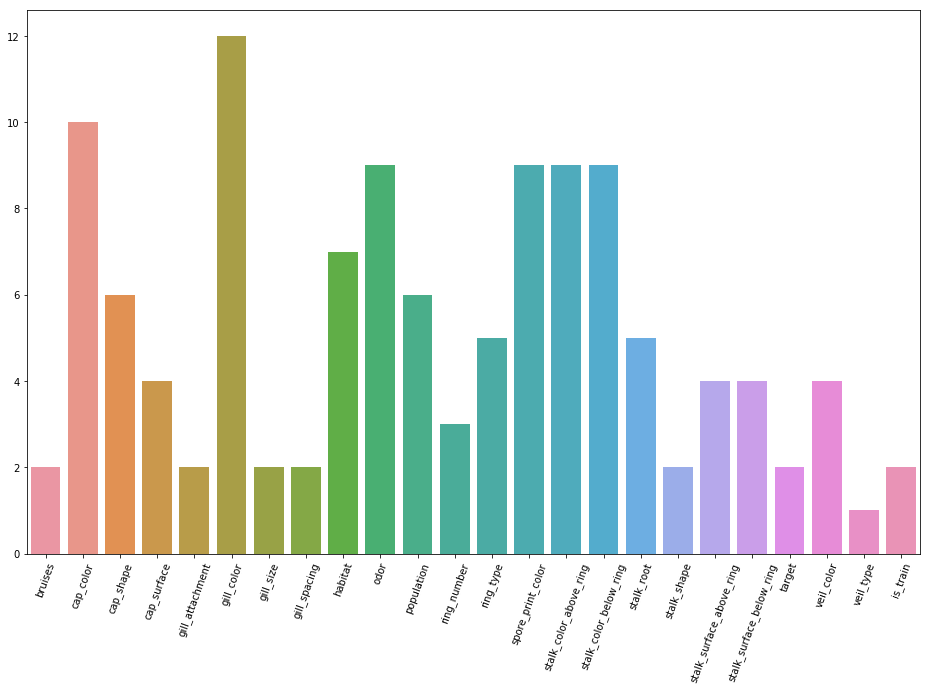

In [172]:
plt.rcParams['figure.figsize'] = (16, 10)
count_of_unique = df.nunique()
fig = sns.barplot(x=count_of_unique.index, y=count_of_unique.values)
for label in fig.get_xticklabels():
    label.set_rotation(70)

### Task 2
**As a preparation, one would spend up to 15-30 minutes on exploratory data analysis (EDA)** - make sure you understand how features are distributed in train/test, what they look like, are they ordinal/binary/categorical before moving further
<br>While doing it, please answer the questions

####  Firstly, split all features on 3 types:
- categorical (more than 2 unique values, no explicit ordering)
- ordinal (more than 2 unique values, explicit ordering)
- binary (2 unique values, doesn't matter whether it has ordering or is "yes/no" styled) 

In [173]:
# ---------------------------------------------------------------
ordinal_cols = sorted(['ring_number'])
binary_cols = sorted(['bruises', 'gill_spacing', 'gill_size', 'stalk_shape', 'gill_attachment'])
non_categorical_cols = ordinal_cols + binary_cols + ['veil_type']
categorical_cols = sorted([i for i in df_train.columns[1:] if not i in non_categorical_cols])
# ---------------------------------------------------------------
print('categorical: {}\nordinal: {}\nbinary: {}'.format(
    len(categorical_cols), len(ordinal_cols), len(binary_cols)))

categorical: 15
ordinal: 1
binary: 5


#### As can be seen from types criteria, feature _ 'veil type' _ is not included on anyone of them.   -->   
                                'veil_type' is redundant for training.

In [174]:
# To be used in training, data must be properly encoded
from collections import defaultdict

# function to encode categorical data


def __encode_categorical(df_list, cat_cols):
    # initialize placeholder
    d = defaultdict(LabelEncoder)
    # fit and encode train/test,
    codes = pd.concat(
        [df[cat_cols] for df in df_list],
        axis=0
    ).fillna('').apply(
        lambda x: d[x.name].fit(x)
    ),
    # transform encodings to train/test etc
    for df in df_list:
        df[cat_cols] = df[cat_cols].fillna('').apply(
            lambda x: d[x.name].transform(x))


# label encode data (categorical + binary)
__encode_categorical(df_list=[df], cat_cols=categorical_cols+binary_cols+['veil_type'] )
# make sure you encode the only ordinal column in correct order
df[ordinal_cols[0]] = df[ordinal_cols[0]].map({'none': 0, 'one': 1, 'two': 2})

# define useful feature columns to be used for training
# (union of all columns discussed above)
columns_to_use = ordinal_cols + binary_cols + categorical_cols

In [175]:
df[columns_to_use].head(2)

,ring_number,bruises,gill_attachment,gill_size,gill_spacing,stalk_shape,cap_color,cap_shape,cap_surface,gill_color,habitat,odor,population,ring_type,spore_print_color,stalk_color_above_ring,stalk_color_below_ring,stalk_root,stalk_surface_above_ring,stalk_surface_below_ring,veil_color
0,1,0,1,1,0,0,0,2,2,10,4,7,3,4,1,7,7,2,3,3,2
1,1,0,1,0,0,1,3,3,0,1,6,6,4,4,1,7,7,0,3,3,2


#### 2.1 Are there any features, obviously redundant to train on? If yes - what are they and why it's better to remove them?

In [176]:
from sklearn.ensemble import ExtraTreesClassifier

def ETC(estimators, depth):
    model = ExtraTreesClassifier(n_estimators=estimators, max_depth=depth)
    xtrain = df.loc[df.is_train, columns_to_use]
    ytrain = df.loc[df.is_train, 'target']

    model.fit(xtrain, ytrain)

    features_df = pd.DataFrame(data=[columns_to_use, list(model.feature_importances_), list(df[columns_to_use].nunique())], 
                               index=['Feature', 'Importance', 'Count of unique items']).T
    return features_df.sort_values('Importance')

data = ETC(1000, None)

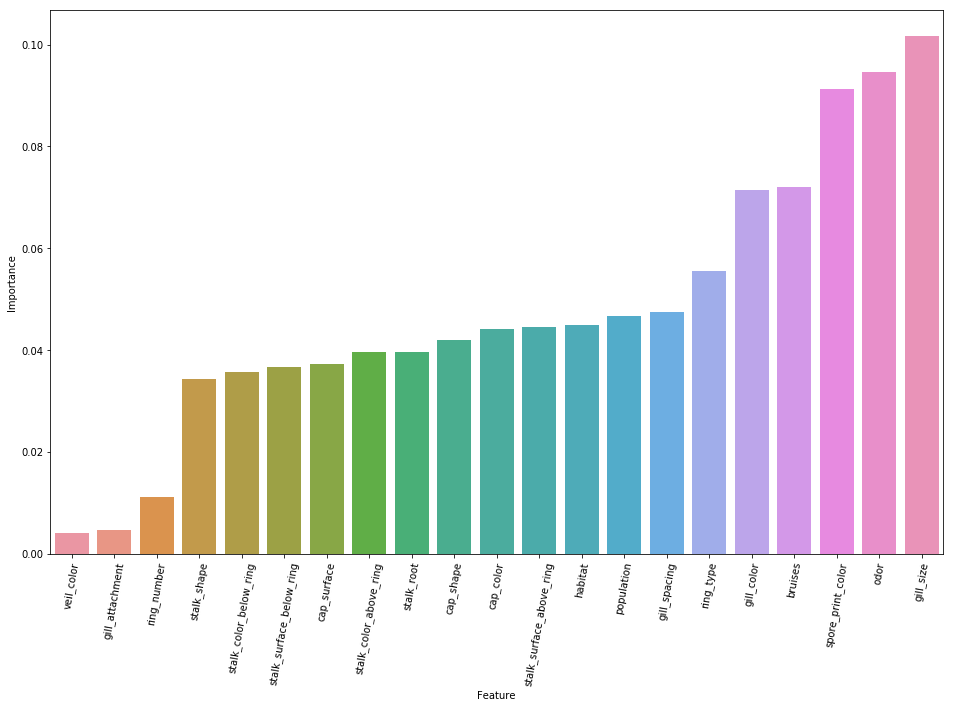

In [177]:
plt.rcParams['figure.figsize'] = (16, 10)
fig = sns.barplot(x=data.Feature, y=data.Importance)
for label in fig.get_xticklabels():
    label.set_rotation(80)

In [178]:
barrier = .04
for feature in columns_to_use:
    groupby_target = df_train.groupby('target')[feature].value_counts(normalize=True)
    data = pd.DataFrame(data = [groupby_target[0], groupby_target[1]], index=['tar_0', 'tar_1']).T.fillna(0)
    data['err'] = data.tar_0 - data.tar_1
    total_error = np.linalg.norm(data.err, ord=1) / (np.linalg.norm(data.tar_0, ord=1) + np.linalg.norm(data.tar_1, ord=1))
    if total_error < barrier:
        print(feature, total_error)

gill_attachment 0.0358610992963454
veil_color 0.039355205686857395


In [179]:
barrier = .97
for feature in columns_to_use:
    val = df[feature].value_counts(normalize=True).max()
    if val > barrier:
        print(feature, val)

gill_attachment 0.9741506646971935
veil_color 0.9753815854258986


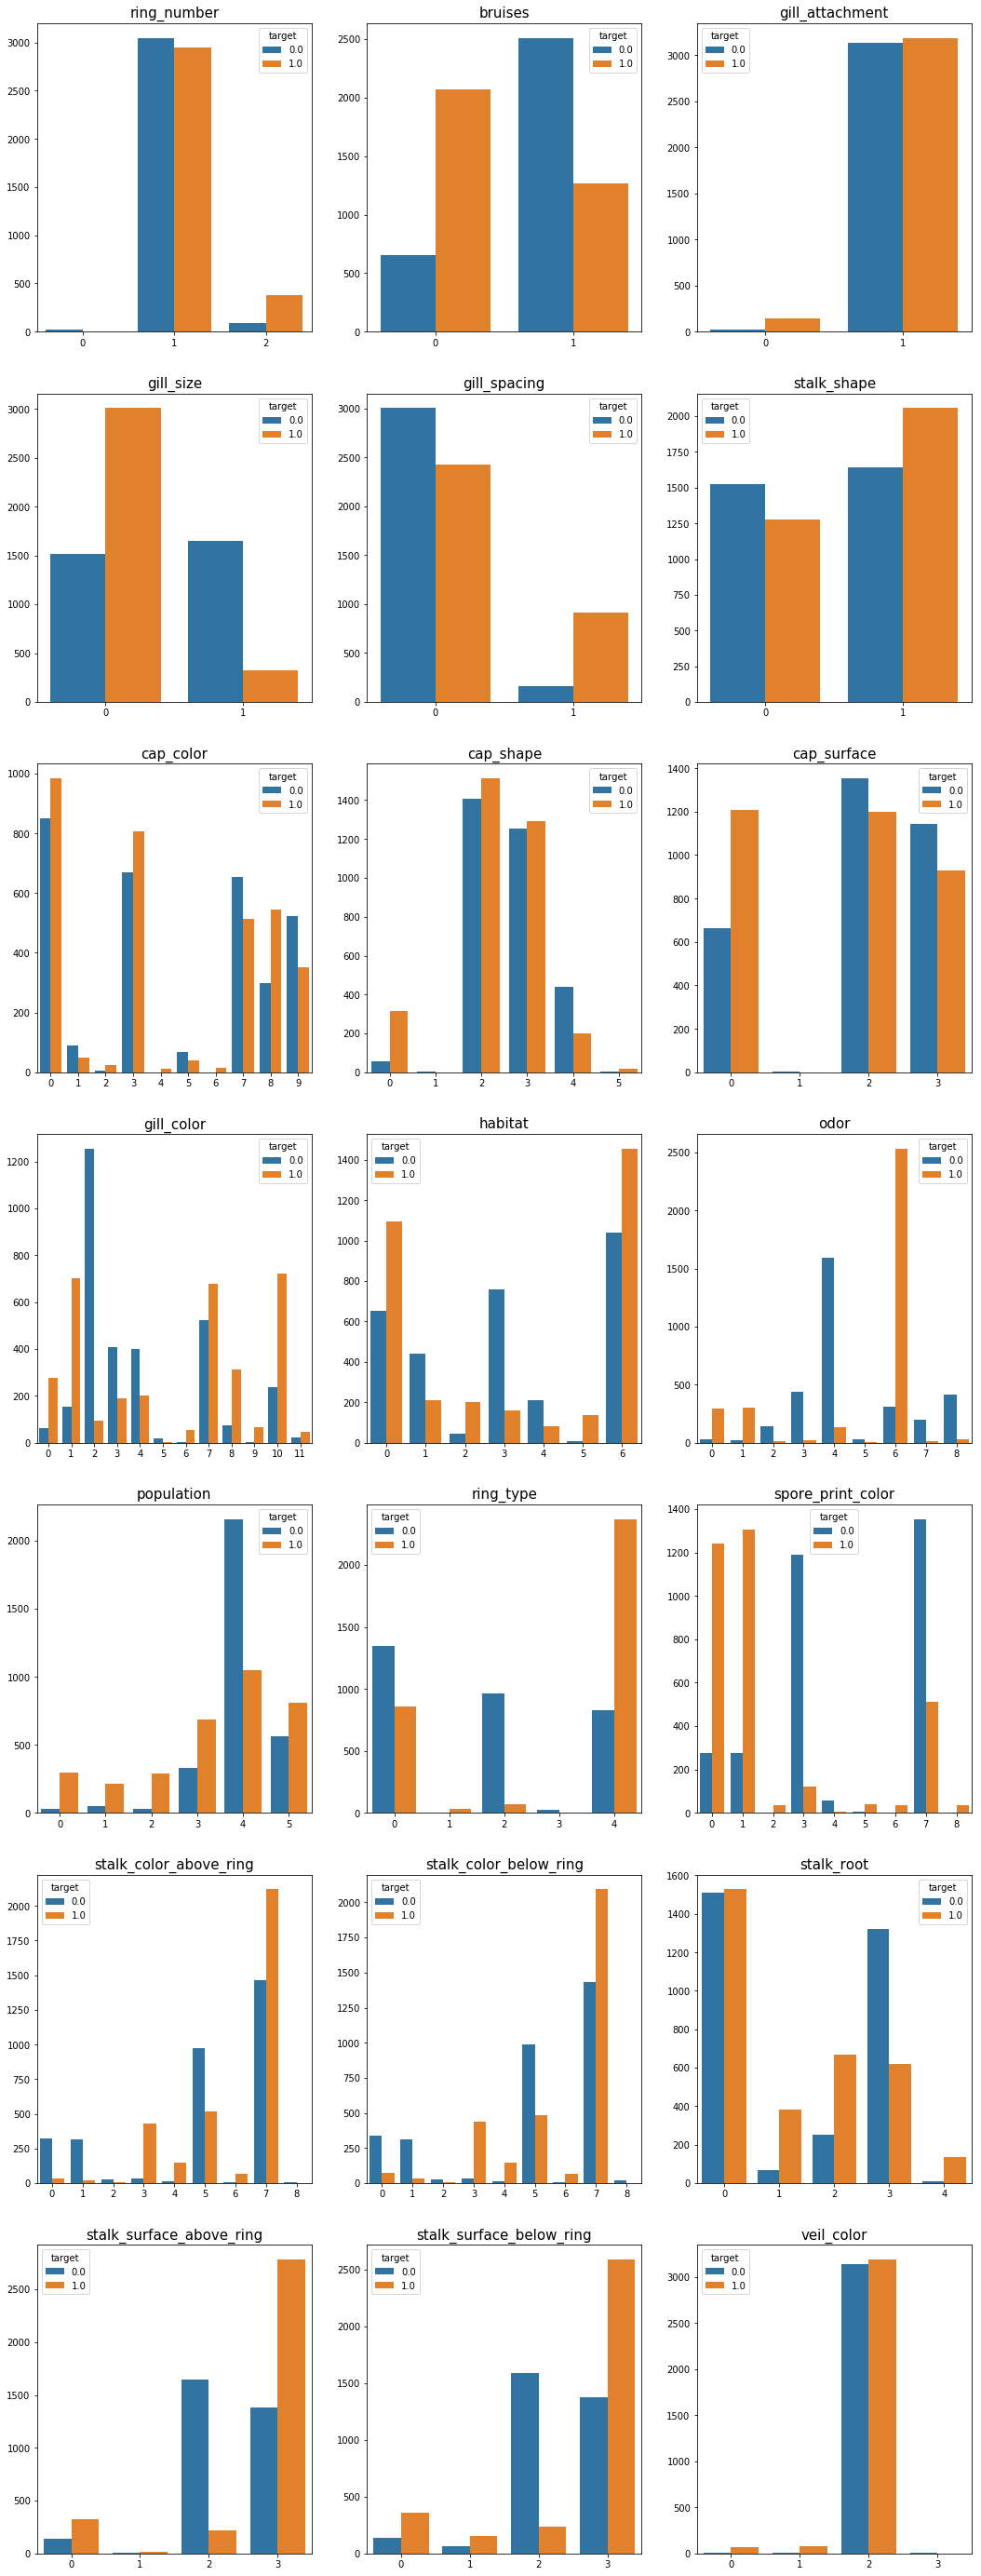

In [180]:
fig, axes = plt.subplots(7, 3, figsize=(18,50))
for ax, column in zip(axes.flatten(), columns_to_use):
    sns.countplot(data=df[df.is_train], x=column, hue='target', ax=ax)
    ax.tick_params(labelsize=10)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(column, fontsize=15)

In [181]:
print(df.shape)
# your code/hardcoded list goes here
# ---------------------------------------------------------------
redundant_columns = ['veil_type'] 
# ---------------------------------------------------------------
# lets drop these columns from joint dataset
df.drop(redundant_columns, axis=1, errors='ignore', inplace=True)
columns_to_use = list(set(columns_to_use).difference(redundant_columns))
print(df.shape)

(8124, 24)
(8124, 23)


### Task 3. Prepare cross-validation strategy and perform comparison of 2 baseline models (linear vs tree-based)

### =====================================================
#### Briefly about Validation / Cross-Validation

Learning the parameters of a prediction function and testing it on the same data is a methodological mistake: a model that would just repeat the labels of the samples that it has just seen would have a perfect score but **would fail to predict anything useful on yet-unseen data. This situation is called overfitting**. 
<br>To avoid it, it is common practice when performing a (supervised) machine learning experiment to hold out part of the available data as a test set ```X_test, y_test```. 
<br>Note that the word “experiment” is not intended to denote academic use only, because even in commercial settings machine learning usually starts out experimentally.

When evaluating different settings (“hyperparameters”) for estimators, **there is still a risk of overfitting on the test set** because the parameters can be tweaked until the estimator performs optimally. 
<br>This way, knowledge about the test set can “leak” into the model and evaluation metrics no longer report on generalization performance. 
<br>To solve this problem, yet another part of the dataset can be held out as a so-called “validation set”: training proceeds on the training set, after which evaluation is done on the validation set, and when the experiment seems to be successful, final evaluation can be done on the test set.

However, by partitioning the available data into three sets, **we drastically reduce the number of samples which can be used for learning the model, and the results can depend on a particular random choice for the pair of (train, validation) sets.**

A solution to this problem is a procedure called **cross-validation (CV for short). A test set should still be held out for final evaluation, but the validation set is no longer needed when doing CV**. In the basic approach, called k-fold CV, the training set is split into k smaller sets (other approaches are described below, but generally follow the same principles). The following procedure is followed for each of the k “folds”:

- A model is trained using k-1 of the folds as training data;
- the resulting model is validated on the remaining part of the data 
<br>(i.e., it is used as a test set to compute a performance measure such as accuracy).
        
<img src="https://hsto.org/files/b1d/706/e6c/b1d706e6c9df49c297b6152878a2d03f.png"/ style="width:75%">

The performance measure reported by k-fold cross-validation **is then the average of the values computed in the loop**. 
<br>This approach can be computationally expensive, but does not waste too much data (as it is the case when fixing an arbitrary test set), which is a major advantage in problem such as inverse inference where the number of samples is very small.


Some classification problems can **exhibit a large imbalance in the distribution of the target classes: for instance there could be several times more negative samples than positive samples**. 
<br>In such cases it is recommended to use **stratified sampling** as implemented in sklearn's StratifiedKFold and StratifiedShuffleSplit to ensure that relative class frequencies is approximately preserved in each train and validation fold.

More details about different cross-validation strategies, implemented in sklearn, can be found [here](http://scikit-learn.org/stable/modules/cross_validation.html)
### =====================================================

Prepare KFold with 5 splits, stratified by target variable, shuffled, with fixed random_state = 42
<br>**Don't forget to filter by column 'is_train'!**
<br>Fit models on subset of features: [columns_to_use]

In [182]:
from os import cpu_count

n_jobs = max(cpu_count() - 1, 1)
# your code goes here
# ---------------------------------------------------------------
# cross-validation iterator
kf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
# xtrain, ytrain, DataFrame-like
xtrain = df.loc[df.is_train, columns_to_use]
ytrain = df.loc[df.is_train, 'target']
# create Decision Tree with default params, max_depth=3, random_state=42
dt = DecisionTreeClassifier( max_depth=3, random_state=42)
# estimate its f1-score with cross-validation (cross_val_score)
# your code goes here
# ---------------------------------------------------------------
scores_dt = cross_val_score(
    estimator=dt,
    X=xtrain,
    y=ytrain,
    scoring='f1',
    cv=kf, # cross-validation strategy
    n_jobs=n_jobs
).mean()
print('DT scoring: {:.4f}'.format(scores_dt))
# ---------------------------------------------------------------
# create Logistic Regression with default params, random_state=42
lr = LogisticRegression(random_state=42)

# estimate its f1-score with cross-validation
# your code goes here
# ---------------------------------------------------------------
scores_lr = cross_val_score(
    estimator=lr,
    X=xtrain, # ...
    y=ytrain, # ...
    scoring='f1',
    cv=kf,
    n_jobs=n_jobs
).mean()
print('LR scoring: {:.4f}'.format(scores_lr))

DT scoring: 0.9012
LR scoring: 0.8904


Why is a score of Linear Regression lower than correspondent one of DT?
1. Is everything OK with the data format for linear models? (revision of 2 previous lectures). 
1. If not, what else you should do to use the data appropriately for linear models?
1. Why didn't point 1. affect Decision Tree performance?

### Task 4. Now it's time to do some hyperparam tuning
Perform suitable hyperparam tuning using created above cross-validation strategy
<br>Main parameters to perform grid-search for:
- max_depth (1,2,...None)
- min_samples_leaf (1,2,...)
- criterion (gini, entropy)
- weight (none, balanced)
- max_features (sqrt(features), 50%, 75%, all of them, ...)
- other params available, see documentation

So - use your fantasy for filling-in abovementioned lists

You should receive **a gain of 0.01 in f1-score or higher**
<br>(current benchmark = +0.0268 gain)

In [205]:
%%time
# your code goes here
# ---------------------------------------------------------------
# create base model (DT, random state = 42)
estimator = DecisionTreeClassifier(
    random_state=42
)

# create parameter grid
# http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
params = {'max_depth': [8],
          'criterion': ['gini', 'entropy'],
          'class_weight' : [None, 'balanced'],
          'max_features': [0.55 - 0.01 * i for i in range(10)],
          'min_samples_leaf': [5, 6, 7],
          'min_samples_split': [2, 3],
          'max_leaf_nodes' : [None, 2],
          'min_impurity_decrease': [0.0, 1e-4],
          'min_weight_fraction_leaf': [0.0, 1e-4],
          'presort': [False, True],
          'splitter': ['best']
}

# create grid search object
gs = GridSearchCV( 
    estimator=estimator,  # base model
    param_grid=params,  # params grid to search within
    cv=kf,  # cross-validation strategy
    error_score=1,  # warnings only
    scoring='f1',  # f1-score
    # thread count, the higher count - the faster
    n_jobs=n_jobs,
    verbose=1,  # messages about performed actions    
)

# perform grid search on TRAIN dataset ('is_train' filtering)
gs.fit(
    X=xtrain, # ...
    y=ytrain, # ...
)
# -------------------------------------------------------------
# extract best score on cross-validation
best_score = gs.best_score_
# extract the estimator (DT) with best params on cross-validation
best_dt = gs.best_estimator_
# check gain in f1-score
print('f1-score best: {:.4f}, +{:.4f} better than baseline'.format(
    best_score, (best_score - scores_dt))
)

Fitting 5 folds for each of 3840 candidates, totalling 19200 fits


[Parallel(n_jobs=3)]: Done 706 tasks      | elapsed:    4.1s
[Parallel(n_jobs=3)]: Done 3706 tasks      | elapsed:   19.8s
[Parallel(n_jobs=3)]: Done 8706 tasks      | elapsed:   47.9s
[Parallel(n_jobs=3)]: Done 15706 tasks      | elapsed:  1.5min
[Parallel(n_jobs=3)]: Done 19200 out of 19200 | elapsed:  1.8min finished


f1-score best: 0.9283, +0.0270 better than baseline
CPU times: user 16.1 s, sys: 343 ms, total: 16.5 s
Wall time: 1min 51s


In [206]:
# take a look on the best model, compare with the baseline
best_dt

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
            max_features=0.52, max_leaf_nodes=None,
            min_impurity_decrease=0.0001, min_impurity_split=None,
            min_samples_leaf=6, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

In [207]:
# check performance on holdout dataset, unseen before (filter 'is_train' == False)

# your code goes here
# ---------------------------------------------------------------
# appropriate df_test data subset from 'df' dataframe
xtest = df.loc[~ df.is_train, columns_to_use] # ...
# fit baseline model 'dt' on xtrain, ytrain (because it's not fitted yet)
dt.fit(xtrain, ytrain)
# ---------------------------------------------------------------

# baseline model
y_true = pd.read_csv(pjoin(DATA_DIR, '4-mushrooms-y_test.csv')) 
y_pred_baseline = dt.predict(xtest)

print('Base on train:   {:.4f}\nBase on holdout: {:.4f}\ndiff: {:.4f}'.format(
    scores_dt, 
    f1_score(y_true, y_pred_baseline),
    scores_dt - f1_score(y_true, y_pred_baseline)
))

# best model
y_pred_best = best_dt.predict(xtest)

print('\nBest on train:   {:.4f}\nBest on holdout: {:.4f}\ndiff: {:.4f}'.format(
    best_score, 
    f1_score(y_true, y_pred_best),
    best_score - f1_score(y_true, y_pred_best)
))

Base on train:   0.9012
Base on holdout: 0.8888
diff: 0.0125

Best on train:   0.9283
Best on holdout: 0.9205
diff: 0.0078


Now you can see that 
<br>**absolute values of f1-score is higher and distance between train|holdout is lower** <br>for **best model** in comparison to **baseline**

**Bonus question**:

Consider two possibilities:
- (a) you have trained **one best** (on cross-validation) Decision Tree
- (b) you randomly choose 25 subsets of 70% of training data, fits "overfitted" (max_depth=None) Decision Trees on it - each of them performs slightly worse than Tree in (a), and then average predicted results over all 25 models (overfitted trees)

**Which one of them would most likely give the best results on hold-out dataset? What makes you think that way?**

In [254]:
from sklearn.model_selection import train_test_split
dt_bonus_b = DecisionTreeClassifier()
pred = []
for i in range(25):
    train_x, _, train_y, _ = train_test_split(xtrain, ytrain, test_size=.3)
    dt_bonus_b.fit(train_x, train_y)
    pred.append(dt_bonus_b.predict(xtest))
test_x = list(map(round, np.array(pred).T.mean(axis=1)))
f1_score(test_x, y_true)

0.8960096735187425